### <b style="color: #abcdef">03.이미지 비전</b>

In [14]:
import  os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

from tools.dataset.five_flowers import get_datasets, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, CLASS_NAMES

#### <b style="color: #fedcba">Pretrained Embedding</b>

> #### <b style="color: #58a491">전이학습</b>
> Pretrained + Custom Header

In [10]:
layers = [
    hub.KerasLayer(
        handle=huburl,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        trainable=False,
        name='mobilenet_embedding'
    ),
    tf.keras.layers.Dense(units=16, activation='relu', name='dense_hidden'),
    tf.keras.layers.Dense(units=len(CLASS_NAMES), activation='softmax', name='flower_prob')
]
model = tf.keras.Sequential(layers, name='flower_classification')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [11]:
model.summary()

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (Keras  (None, 1280)              2257984   
 Layer)                                                          
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2278565 (8.69 MB)
Trainable params: 20581 (80.39 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [12]:
train_dataset, eval_dataset = get_datasets()

In [13]:
history = model.fit(train_dataset, epochs=10, validation_data=eval_dataset)
df_history = pd.DataFrame(history.history)

Epoch 1/10


2024-01-23 11:30:47.039405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


    193/Unknown - 13s 48ms/step - loss: 1.3270 - accuracy: 0.4745

2024-01-23 11:30:59.121509: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3062296863072899141
2024-01-23 11:30:59.121521: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15258616226245340531
2024-01-23 11:30:59.121525: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13277151829478426123
2024-01-23 11:30:59.282496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


193/193 [==============================] - 18s 71ms/step - loss: 1.3270 - accuracy: 0.4745 - val_loss: 1.0123 - val_accuracy: 0.6141
Epoch 2/10
  3/193 [..............................] - ETA: 8s - loss: 0.6701 - accuracy: 0.8333 

2024-01-23 11:31:03.605530: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6342914914658064542


193/193 [==============================] - 12s 61ms/step - loss: 0.8182 - accuracy: 0.7175 - val_loss: 0.7373 - val_accuracy: 0.7209
Epoch 3/10
193/193 [==============================] - 12s 61ms/step - loss: 0.6178 - accuracy: 0.7908 - val_loss: 0.6068 - val_accuracy: 0.7755
Epoch 4/10
193/193 [==============================] - 12s 61ms/step - loss: 0.5110 - accuracy: 0.8278 - val_loss: 0.5340 - val_accuracy: 0.8095
Epoch 5/10
193/193 [==============================] - 12s 61ms/step - loss: 0.4421 - accuracy: 0.8585 - val_loss: 0.4896 - val_accuracy: 0.8265
Epoch 6/10
193/193 [==============================] - 12s 61ms/step - loss: 0.3936 - accuracy: 0.8741 - val_loss: 0.4572 - val_accuracy: 0.8422
Epoch 7/10
193/193 [==============================] - 12s 61ms/step - loss: 0.3567 - accuracy: 0.8876 - val_loss: 0.4302 - val_accuracy: 0.8544
Epoch 8/10
193/193 [==============================] - 12s 61ms/step - loss: 0.3251 - accuracy: 0.9022 - val_loss: 0.4120 - val_accuracy: 0.8568
Epo

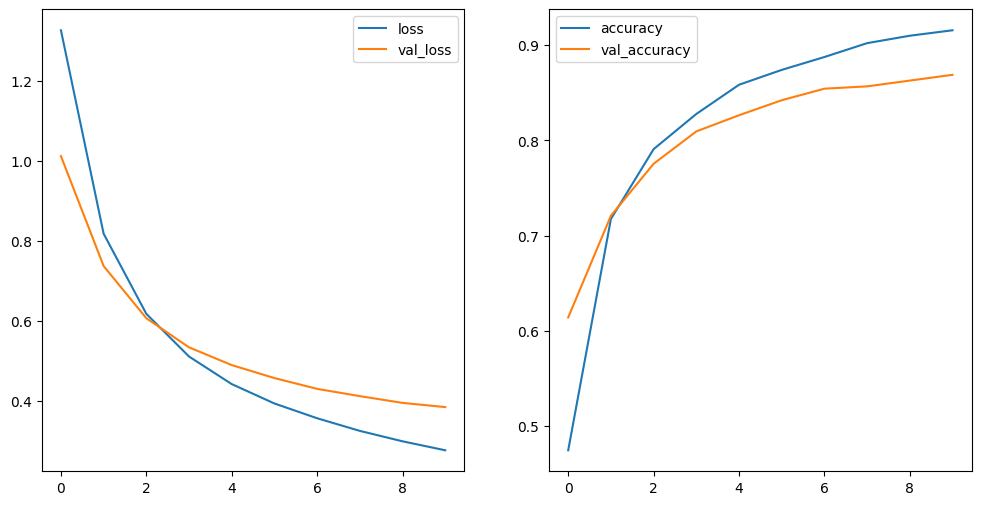

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
df_history[['loss', 'val_loss']].plot(ax=axes[0])
df_history[['accuracy', 'val_accuracy']].plot(ax=axes[1])
plt.show()

1/1 [==============================] - 0s 81ms/step


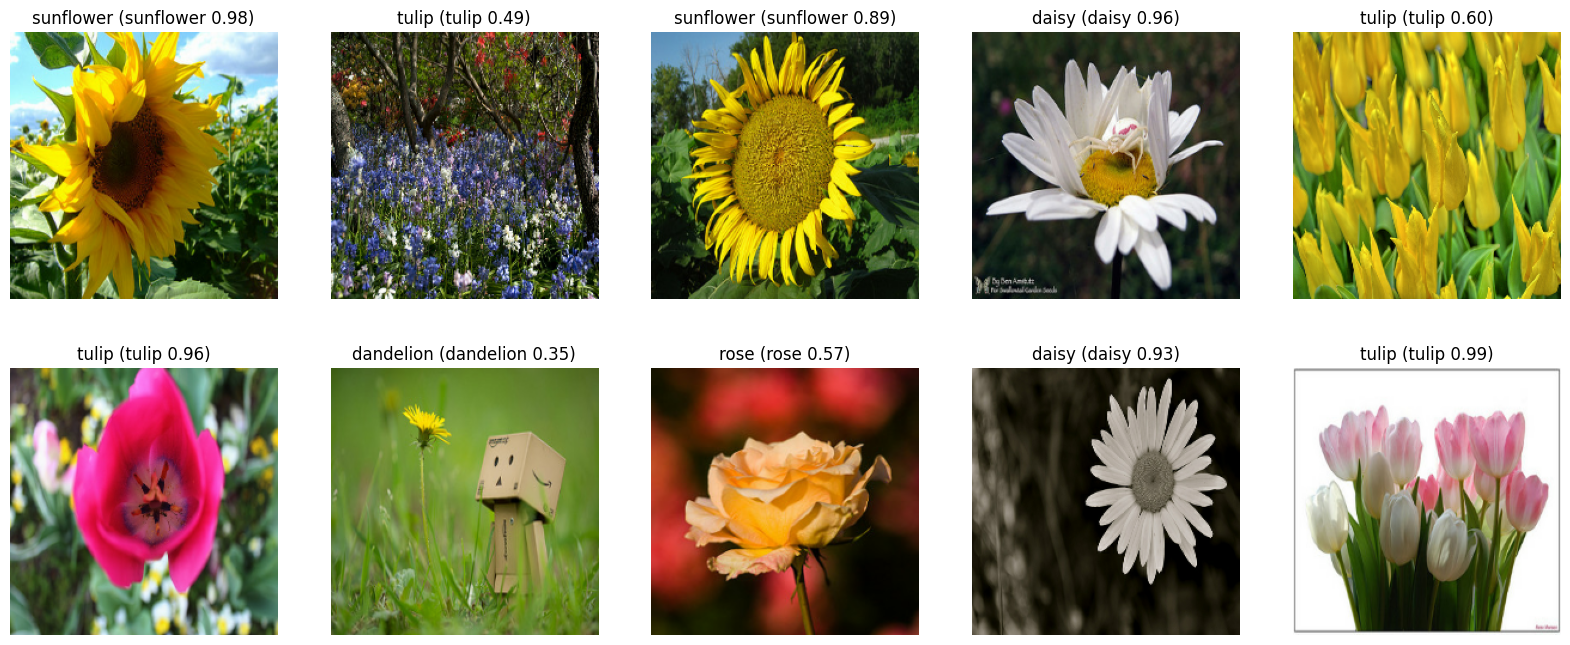

In [28]:
import tools.train.plot as tp
import importlib

importlib.reload(tp)

imgs, labels = next(iter(eval_dataset))
tp.show_images(model, imgs, labels, class_names=CLASS_NAMES)

> #### <b style="color: #58a491">파인튜닝</b>
> Pretrained 가중치 초기값 세팅
> - 학습률 스케줄: 높은 학습률로 시작해서 점점 낮춰감
> - 차등 학습률: 레이어별로 학습률을 달리하나?

In [17]:
len(imgs)

10